In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [10]:
tickerSymbol = 'AMZN'
textChoice = 'title' # 'content'

dataFile = '../Data/' + tickerSymbol + '_' + textChoice + '_' + 'NewsDataset.csv'

In [11]:
# Change this seed for a different shuffle. 
# Seed is here to create reproducible results, if needed. 
SHUFFLE_SEED = 12345

stockDF = pd.read_csv(dataFile)
stockDF = stockDF.sample(frac=1, random_state=SHUFFLE_SEED)

In [12]:
N = len(stockDF)
BATCH_SIZE = 32
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.2

trainSize = int(N * TRAIN_PERCENT)
validSize = int(trainSize * VALID_PERCENT)

train_df = stockDF.iloc[:trainSize-validSize]
valid_df = stockDF.iloc[trainSize-validSize:trainSize]
test_df  = stockDF.iloc[trainSize: N]

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Text'],train_df['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['Text'],valid_df['Label']))
test_ds  = tf.data.Dataset.from_tensor_slices((test_df['Text'],test_df['Label']))

train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds  = test_ds.batch(BATCH_SIZE)

In [15]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda Text, Label: Text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'amazon', 'earnings', 'stock', 'q3', 'new', 'stocks',
       'buy', 'sales', 'estimates', 'beat', 'com', 'shares', 'q4', '3',
       'top', 'market', 'growth', 'brazil'], dtype='<U15')

In [17]:
L2_REGULARIZATION = 0.1

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dense(1)
])

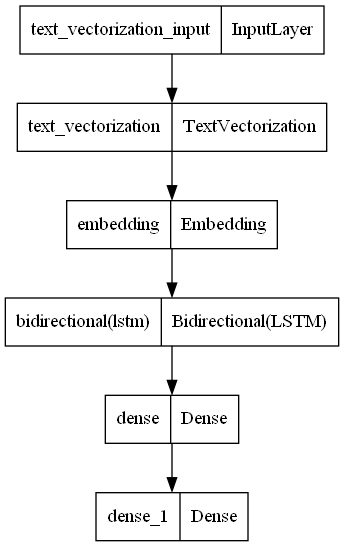

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.02679332]


In [21]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 70ms/step
[-0.02679331]


In [22]:
EPOCHS = 12
VALIDATION_STEPS = 20
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(1e-4)
#metrics = tf.metrics.BinaryAccuracy()
metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy']

In [23]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [24]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/12
112/112 [==============================] - 5s 14ms/step - loss: 26.5561 - binary_crossentropy: 0.6923 - accuracy: 0.4498 - val_loss: 23.6348 - val_binary_crossentropy: 0.6924 - val_accuracy: 0.4812
Epoch 2/12
112/112 [==============================] - 0s 4ms/step - loss: 21.1653 - binary_crossentropy: 0.6901 - accuracy: 0.4498 - val_loss: 18.8236 - val_binary_crossentropy: 0.6921 - val_accuracy: 0.4812
Epoch 3/12
112/112 [==============================] - 0s 4ms/step - loss: 16.8378 - binary_crossentropy: 0.6887 - accuracy: 0.4498 - val_loss: 14.9578 - val_binary_crossentropy: 0.6922 - val_accuracy: 0.4812
Epoch 4/12
112/112 [==============================] - 0s 4ms/step - loss: 13.3615 - binary_crossentropy: 0.6879 - accuracy: 0.4498 - val_loss: 11.8546 - val_binary_crossentropy: 0.6924 - val_accuracy: 0.4812
Epoch 5/12
112/112 [==============================] - 0s 4ms/step - loss: 10.5749 - binary_crossentropy: 0.6875 - accuracy: 0.4498 - val_loss: 9.3714 - val_binary_cros

In [25]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

35/35 [==============================] - 0s 2ms/step - loss: 1.8759 - binary_crossentropy: 0.6909 - accuracy: 0.4669
Test Loss: 1.8759119510650635
Test Binary Cross Entropy: 0.6908703446388245
Test Accuracy: 0.4669051766395569


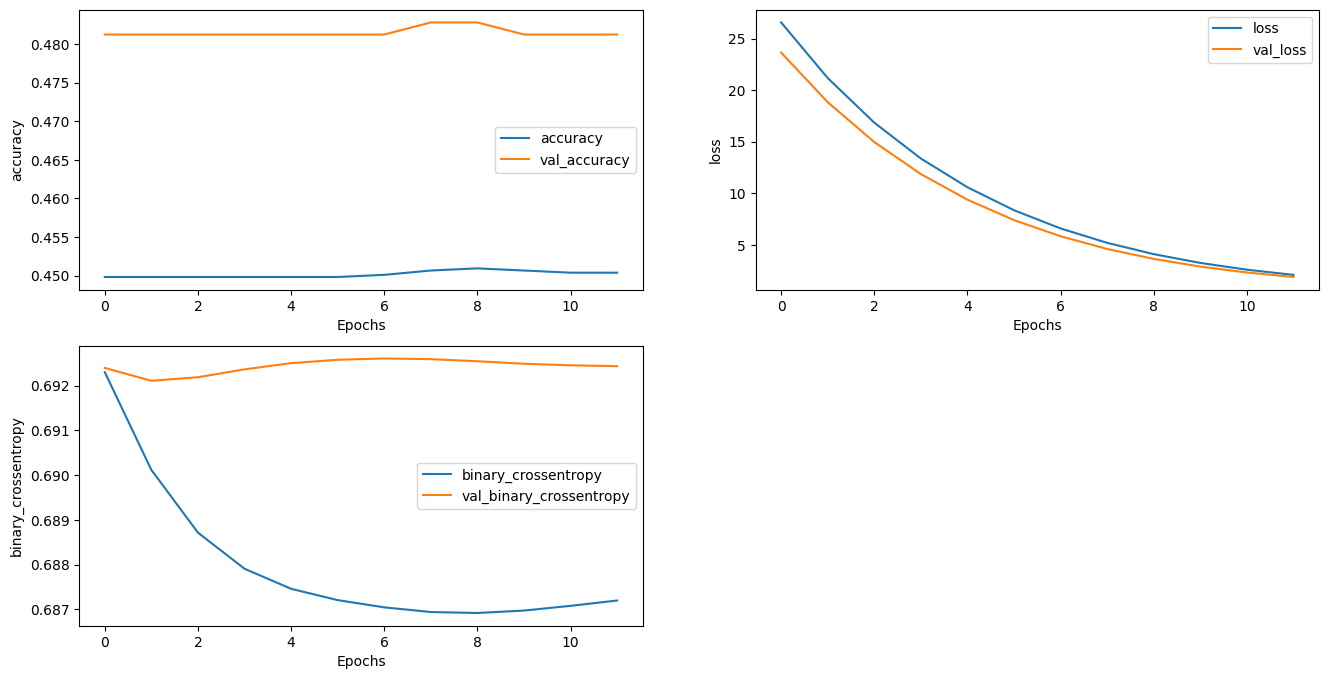

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

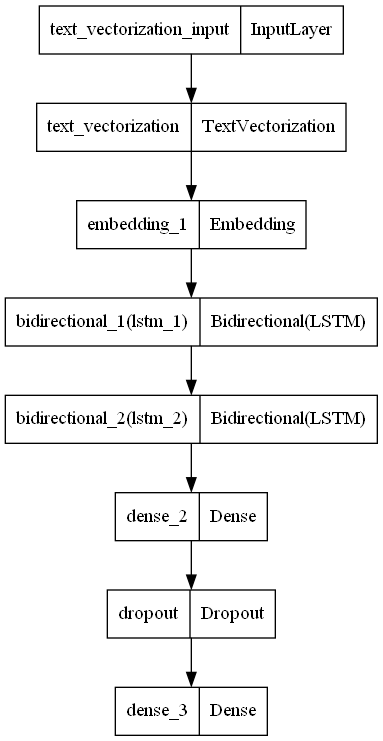

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [30]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/12
112/112 [==============================] - 9s 27ms/step - loss: 33.5300 - binary_crossentropy: 0.6902 - accuracy: 0.4498 - val_loss: 21.6765 - val_binary_crossentropy: 0.6922 - val_accuracy: 0.4812
Epoch 2/12
112/112 [==============================] - 1s 7ms/step - loss: 16.5039 - binary_crossentropy: 0.6889 - accuracy: 0.4498 - val_loss: 12.4717 - val_binary_crossentropy: 0.6924 - val_accuracy: 0.4812
Epoch 3/12
112/112 [==============================] - 1s 7ms/step - loss: 9.9694 - binary_crossentropy: 0.6883 - accuracy: 0.4498 - val_loss: 7.8798 - val_binary_crossentropy: 0.6925 - val_accuracy: 0.4812
Epoch 4/12
112/112 [==============================] - 1s 7ms/step - loss: 6.4557 - binary_crossentropy: 0.6887 - accuracy: 0.4498 - val_loss: 5.2357 - val_binary_crossentropy: 0.6926 - val_accuracy: 0.4812
Epoch 5/12
112/112 [==============================] - 1s 7ms/step - loss: 4.3679 - binary_crossentropy: 0.6892 - accuracy: 0.4498 - val_loss: 3.6161 - val_binary_crossentr

In [31]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

35/35 [==============================] - 0s 2ms/step - loss: 0.8457 - binary_crossentropy: 0.6910 - accuracy: 0.4669
Test Loss: 0.8456852436065674
Test Binary Cross Entropy: 0.6910362243652344
Test Accuracy: 0.4669051766395569


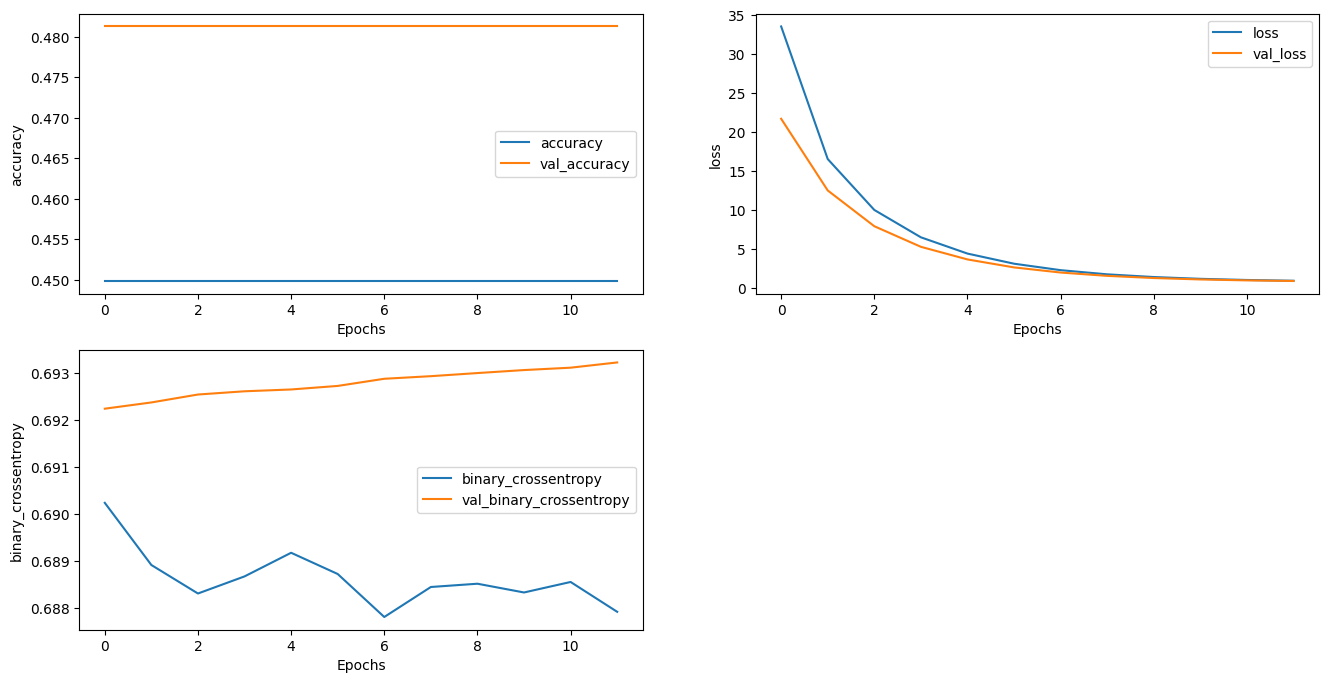

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)